In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betavae import BetaVAE, compile_vae, extract_latent_dimensions, weights
from optimize_utils import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "BetaVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Train Loss: 235.43459217583955, Val Loss: 396.9234890407986, Test Loss: 406.8951687282986
Epoch 2, Train Loss: 213.10331885494404, Val Loss: 470.1539713541667, Test Loss: 490.24237738715277
Epoch 3, Train Loss: 198.65909077658583, Val Loss: 339.1488308376736, Test Loss: 351.65553114149304
Epoch 4, Train Loss: 186.00217904617537, Val Loss: 244.5477294921875, Test Loss: 250.19179958767361
Epoch 5, Train Loss: 176.03696944962687, Val Loss: 199.33268229166666, Test Loss: 197.08804660373264
Epoch 6, Train Loss: 165.85666103078358, Val Loss: 181.34747992621527, Test Loss: 171.62824164496527
Epoch 7, Train Loss: 156.31660739272388, Val Loss: 204.5074462890625, Test Loss: 183.32689073350696
Epoch 8, Train Loss: 147.64808768656715, Val Loss: 154.5080769856771, Test Loss: 145.56654188368054
Epoch 9, Train Loss: 135.11344522504663, Val Loss: 212.3095906575521, Test Loss: 202.31641303168402
Epoch 10, Train Loss: 129.75750859958023, Val Loss: 185.04351806640625, Test Loss: 173.582187228732

In [5]:
# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [6]:
# Save training history
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

history_path = pathlib.Path("results/training_history.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

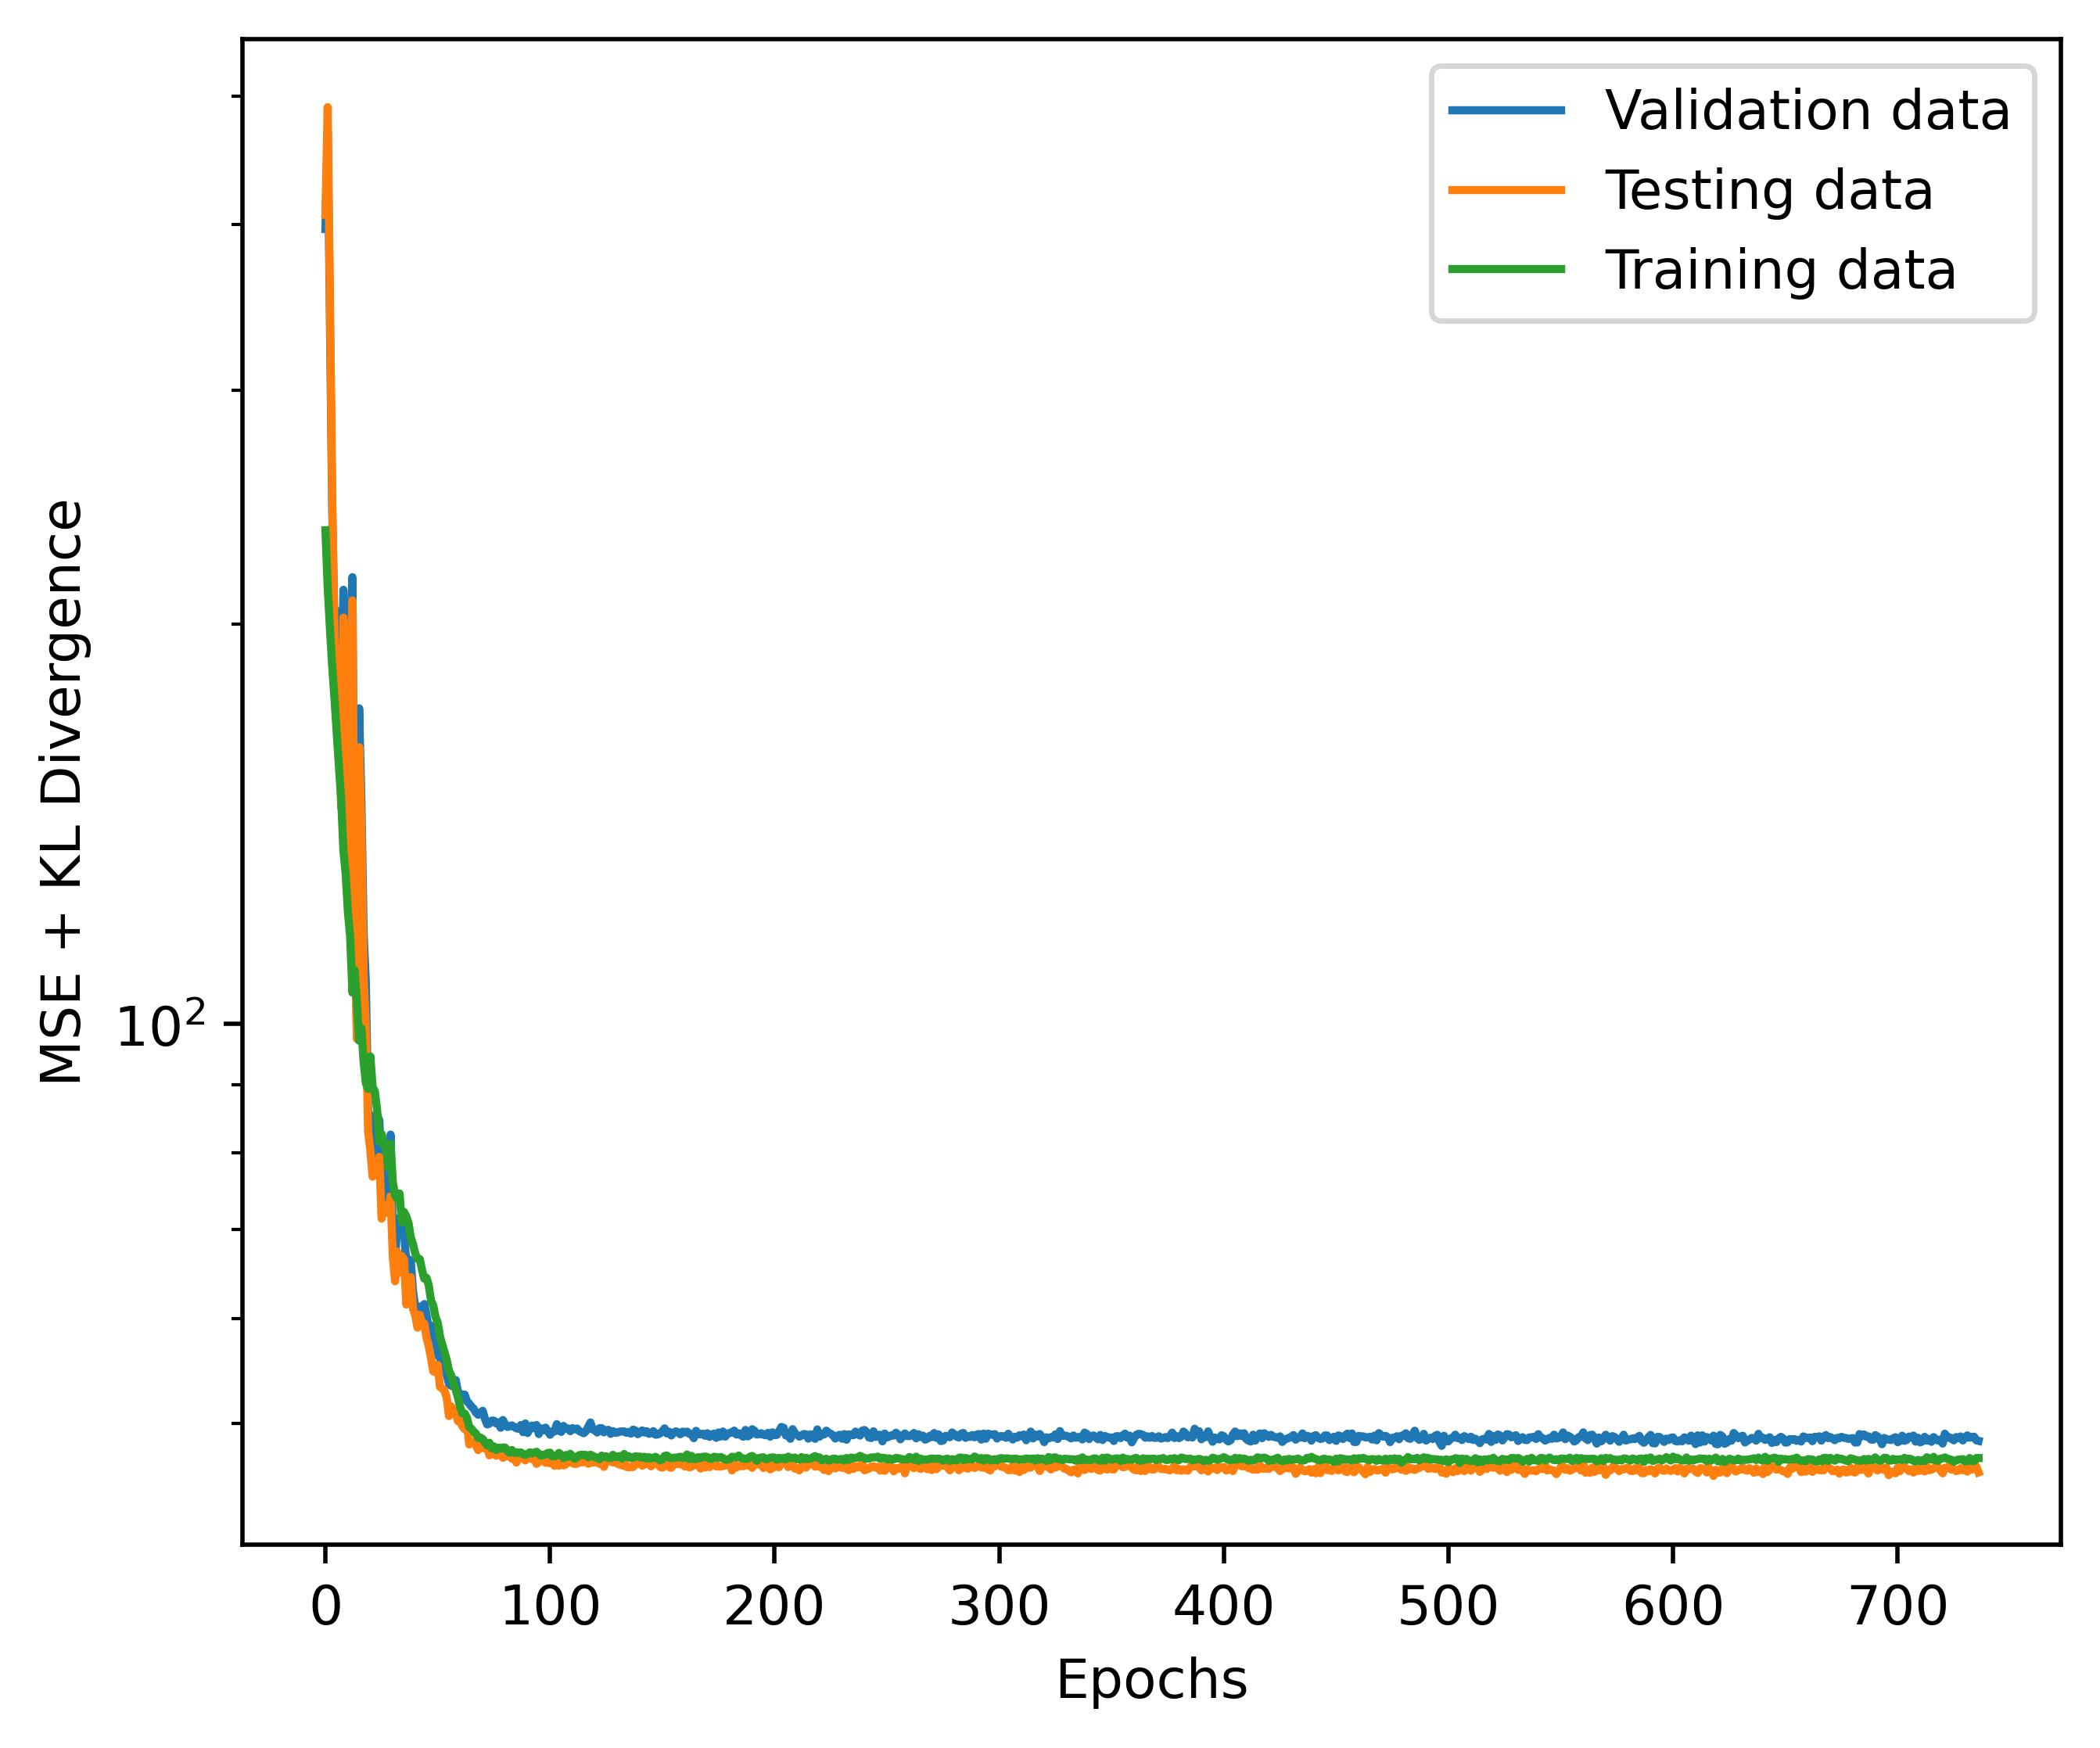

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

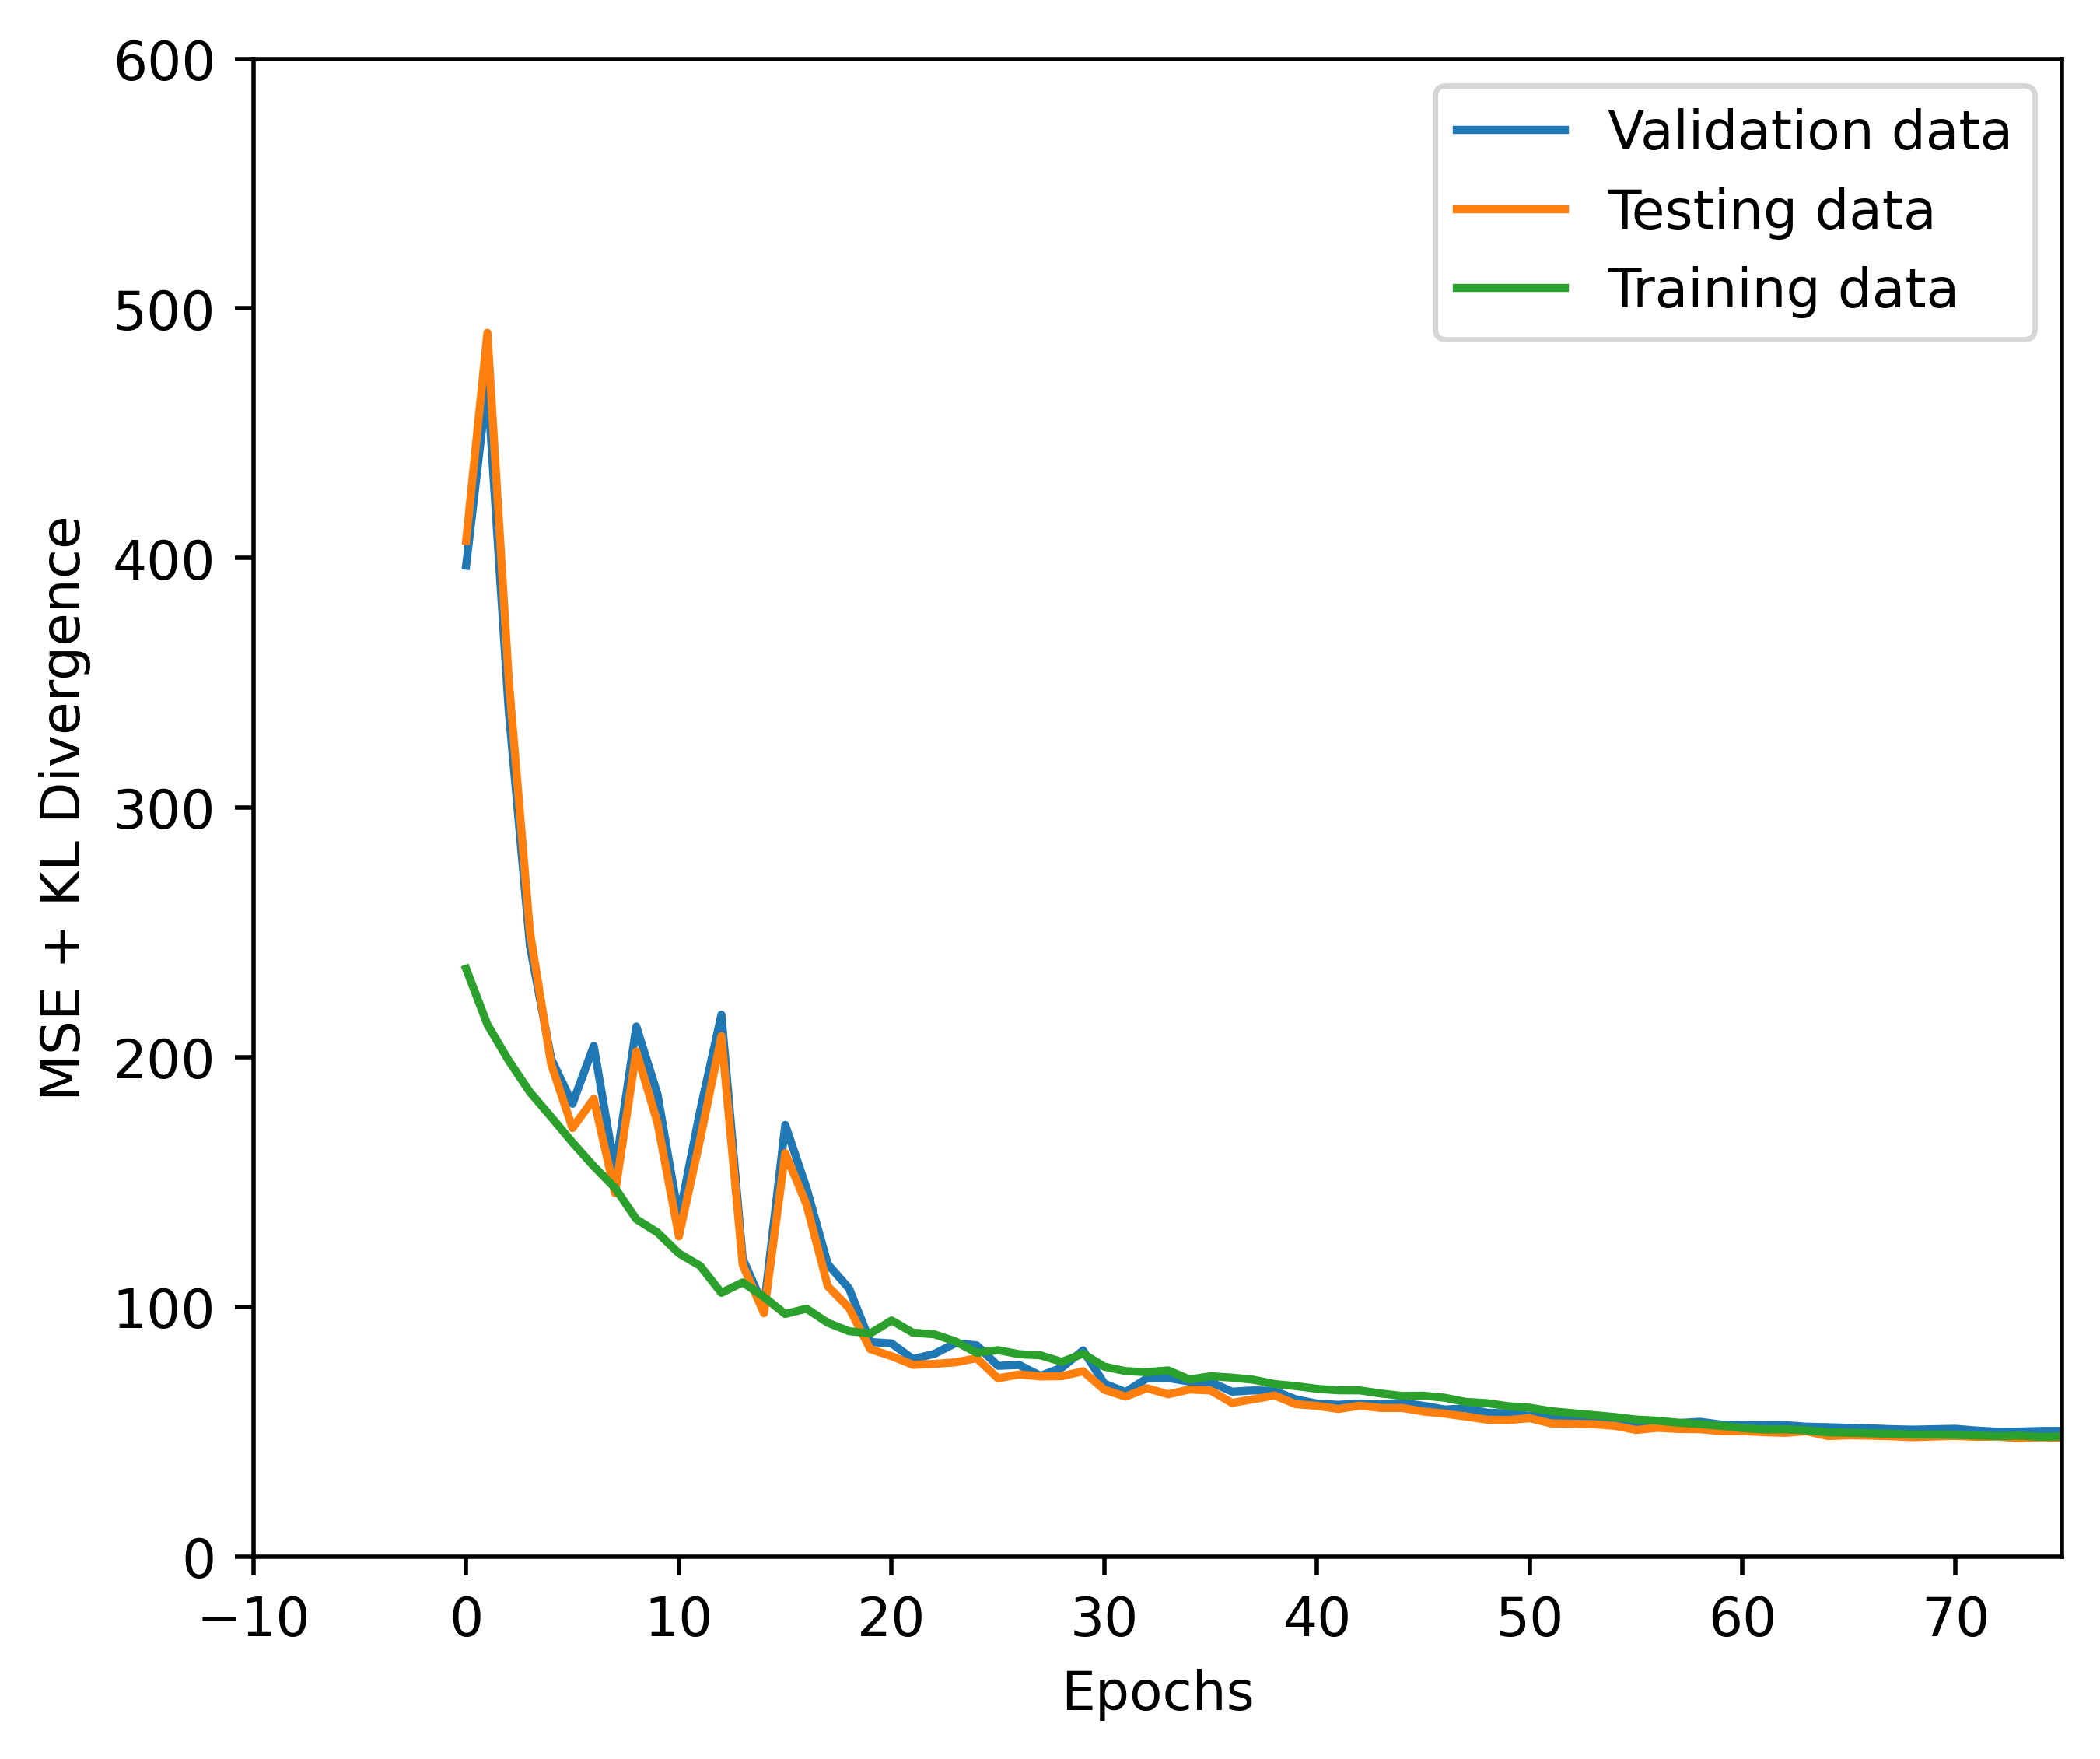

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-10,75)
plt.ylim(0,600)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata = pd.read_csv(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.csv")
train_and_test_subbed = pd.read_csv(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata)
print(latent_df.head())

#Save as CSV
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

      ModelID         0    1         2    3         4         5         6  \
0  ACH-000515  0.189114  0.0  0.096250  0.0  0.036446  0.629606  0.252834   
1  ACH-000159  0.000000  0.0  0.000000  0.0  0.000000  0.265836  0.028981   
2  ACH-000672  0.000000  0.0  0.000000  0.0  0.000000  0.386246  0.005057   
3  ACH-000210  0.045557  0.0  0.000000  0.0  0.000000  0.478783  0.133152   
4  ACH-000947  0.422633  0.0  0.328416  0.0  0.146769  0.923145  0.543198   

     7    8  ...        66   67        68        69   70   71   72        73  \
0  0.0  0.0  ...  0.762887  0.0  0.212375  2.171131  0.0  0.0  0.0  0.109546   
1  0.0  0.0  ...  0.414227  0.0  0.000000  0.446916  0.0  0.0  0.0  0.000000   
2  0.0  0.0  ...  0.469707  0.0  0.000000  0.560958  0.0  0.0  0.0  0.000000   
3  0.0  0.0  ...  0.565899  0.0  0.017124  1.329373  0.0  0.0  0.0  0.000000   
4  0.0  0.0  ...  1.029423  0.0  0.244209  2.895266  0.0  0.0  0.0  0.040911   

    74        75  
0  0.0  2.341959  
1  0.0  1.948929  

In [10]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train"
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_csv(
    "../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter="\t"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data)